## Spatial multi-criteria analysis for the strategic spatial placement of blue-green infrastructure

The goal of this jupyter notebook is to handle the analysis and data (pre)processing of 

In [1]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import rasterio as rio
from rasterio.plot import show

In [2]:
gdf = gpd.read_file(
    filename="./Data/ribu_wur_soildata.gpkg"
)

gdf.dropna(subset='lutumgehalte', inplace=True)

topsoil_samples = gdf[(gdf['BOVENKANT'] < 0.2) & (gdf['ONDERKANT'].between(0.2, 0.5))]

subsoil_samples = gdf[(gdf['BOVENKANT'] > 0.2) & (gdf['ONDERKANT'] > 0.5)]

In [3]:
# We can calculate the leem fraction as 100 - sand fraction. The sand fraction can be approximated from the soc using the formula: sand = -6 * soc + 82
topsoil_samples['leem'] = 100 - (-6 * topsoil_samples['organisch_stofgehalte'] + 82)
subsoil_samples['leem'] = 100 - (-6 * subsoil_samples['organisch_stofgehalte'] + 82)

/home/vscode/.local/lib/python3.12/site-packages/geopandas/geodataframe.py:1981: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/home/vscode/.local/lib/python3.12/site-packages/geopandas/geodataframe.py:1981: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


In [4]:
topsoil_samples.head()

,datum,boorpunt_ID,BOVENKANT,ONDERKANT,analysemonster_ID,lutumgehalte,organisch_stofgehalte,geometry,leem
4,NaT,12088,0.1,0.5,8616,1.0,0.8,POINT (121641 483535),22.8
16,NaT,17290,0.0,0.5,12928,1.0,0.7,POINT (122317 483576),22.2
17,NaT,17291,0.0,0.5,12929,5.0,11.9,POINT (122284 483579),89.4
20,NaT,17357,0.0,0.5,12973,1.0,0.4,POINT (121484 483339),20.4
22,NaT,17365,0.0,0.2,12979,1.5,16.9,POINT (122391.906 484589.127),119.4


In [5]:
# First, we retrieve the soil type from the lutumgehalte column.
# We can do this because the Netherlands, and thus Amsterdam as well, has a limited number of soil types that can be derived almost solely from the lutumgehalte.
def determine_topsoil_type(lutumfractie, os, leem):
    if 0 <= os <= 15:
        if 0 <= lutumfractie <= 8:
            if 0 <= leem <= 10:
                return "B01"
            elif 10 < leem <= 18:
                return "B02"
            elif 18 < leem <= 33:
                return "B03"
            elif 33 < leem <= 50:
                return "B04"
            elif 50 < leem <= 100:
                return "B05"
        if 8 < lutumfractie <= 12:
            return "B07"
        elif 12 < lutumfractie <= 18:
            return "B08"
        elif 18 < lutumfractie <= 25:
            return "B09"
        elif 25 < lutumfractie <= 35:
            return "B10"
        elif 35 < lutumfractie <= 50:
            return "B11"
        elif 50 < lutumfractie <= 100:
            return "B12"
    elif lutumfractie < 8:
        if 15 < os < 25:
            return "B15"
        elif 25 < os:
            return "B16"
    elif lutumfractie > 8:
        if 16 < os < 45:
            return "B17"
        elif 45 < os < 70:
            return "B18"
        
    
def determine_subsoil_type(lutumfractie, os, leem):
    if 0 <= os <= 3:
        if 0 <= lutumfractie <= 8:
            if 0 <= leem <= 10:
                return "O01"
            elif 10 < leem <= 18:
                return "O02"
            elif 18 < leem <= 33:
                return "O03"
            elif 33 < leem <= 50:
                return "O04"
            elif 50 < leem <= 100:
                return "O05"
        if 8 < lutumfractie <= 12:
            return "O08"
        elif 12 < lutumfractie <= 18:
            return "O09"
        elif 18 < lutumfractie <= 25:
            return "O10"
        elif 25 < lutumfractie <= 35:
            return "O11"
        elif 35 < lutumfractie <= 50:
            return "O12"
        elif 50 < lutumfractie <= 100:
            return "O13"
    elif 15 <= os <= 35:
        return "O18"
    elif 35 <= os <= 100:
        return "O17"


In [6]:
topsoil_samples['type'] = topsoil_samples.apply(
    lambda row: determine_topsoil_type(row['lutumgehalte'], row['organisch_stofgehalte'], row['leem']),
    axis=1
)

subsoil_samples['type'] = subsoil_samples.apply(
    lambda row: determine_subsoil_type(row['lutumgehalte'], row['organisch_stofgehalte'], row['leem']),
    axis=1
)

# Save the topsoil and subsoil samples to separate geopackage files
topsoil_samples.to_file(
    filename="./Data/topsoil_samples.gpkg",
    driver="GPKG",
    layer="topsoil_samples"
)   

subsoil_samples.to_file(
    filename="./Data/subsoil_samples.gpkg",
    driver="GPKG",
    layer="subsoil_samples"
)

/home/vscode/.local/lib/python3.12/site-packages/geopandas/geodataframe.py:1981: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/home/vscode/.local/lib/python3.12/site-packages/geopandas/geodataframe.py:1981: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


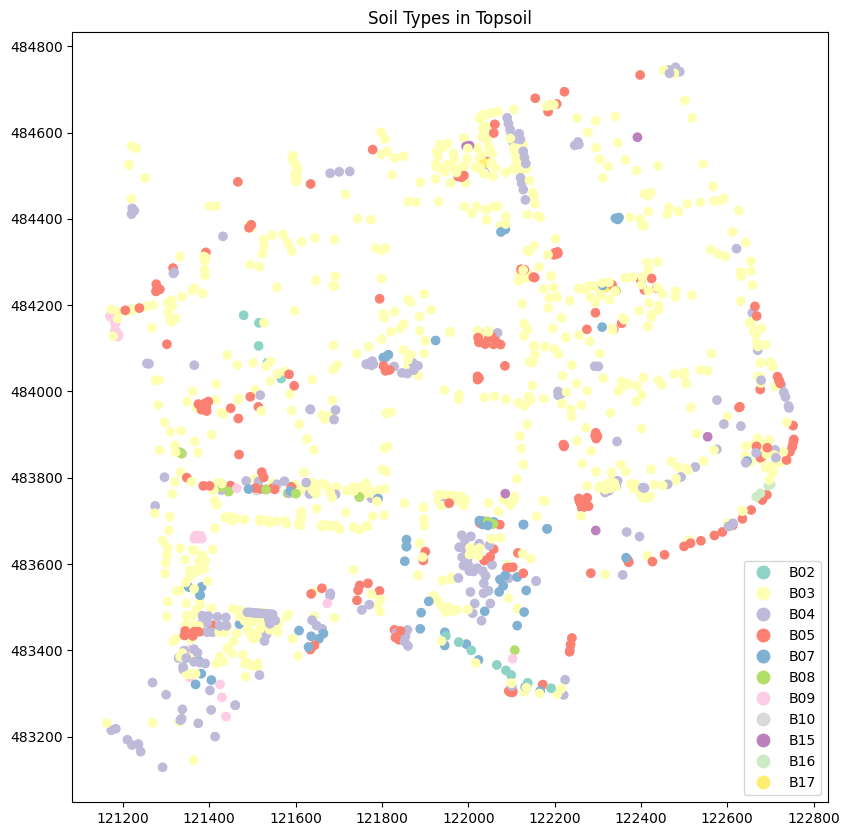

In [7]:
# Plot the soil types in the topsoil
fig, ax = plt.subplots(figsize=(10, 10))
topsoil_samples.plot(column='type', ax=ax, legend=True, cmap='Set3')
ax.set_title('Soil Types in Topsoil')
plt.show()

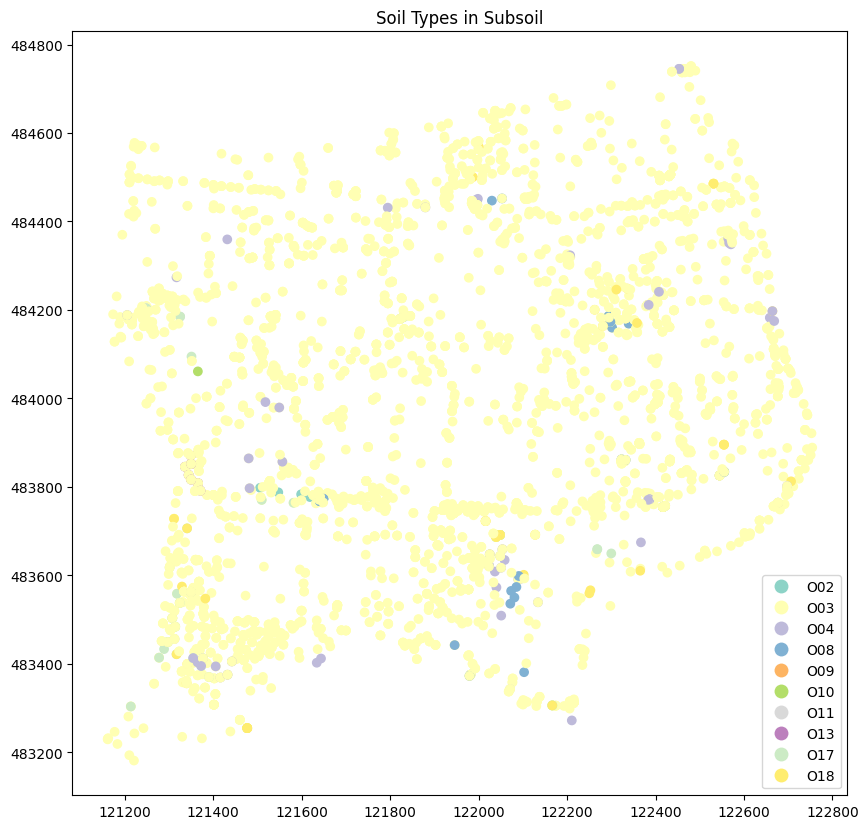

In [8]:
# Plot the soil types in the subsoil
fig, ax = plt.subplots(figsize=(10, 10))
subsoil_samples.plot(column='type', ax=ax, legend=True, cmap='Set3')
ax.set_title('Soil Types in Subsoil')
plt.show()

In [9]:
# Load the waternet data which has been taken from the waternet website using the esri REST API.
# The data contains the peilbuizen (water level measurement points) in Amsterdam.
# The data is in a geopackage format.
waternet_gdf = gpd.read_file("./Data/waternet_peilbuizen.gpkg", layer="peilbuis_ribu")

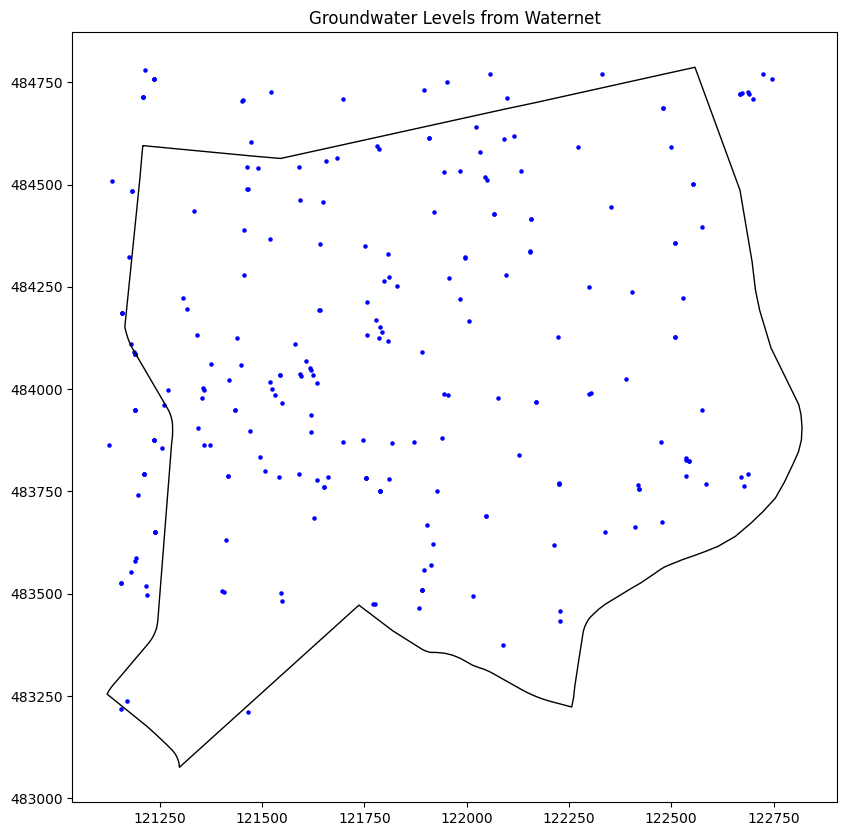

In [10]:
researcharea = gpd.read_file("./Data/ribu_shape.gpkg")

# Select the waternet data that is within the research area
# waternet_gdf = waternet_gdf.clip(researcharea)

# Plot the waternet_gdf to see the groundwater levels
fig, ax = plt.subplots(figsize=(10, 10))
waternet_gdf.plot(ax=ax, color='blue', markersize=5)
researcharea.plot(ax=ax, edgecolor='black', facecolor='none')
ax.set_title('Groundwater Levels from Waternet')
plt.show()

In [11]:
# The waternet data does not contain the groundwater levels, but rather the water level measurement points.
# We can use the water level measurement points to retrieve the latest groundwater levels from the waternet website.
# The water level measurement points are in the form of a URL that can be used to access a small website with the latest groundwater levels.
# The URL is in the form of: https://pims.waternet.nl/maps/peilbuizen.cfm?put=10331
# We can use the requests library to retrieve the data from the URL and parse the HTML to get the latest groundwater levels.
import requests
from bs4 import BeautifulSoup

def get_latest_stijghgt_from_html(html):
    soup = BeautifulSoup(html, 'html.parser')
    # Find the table with measurement data (the second table in the page)
    tables = soup.find_all('table')
    if len(tables) < 2:
        return None  # Table not found

    data_table = tables[2]
    # Find all rows, skip the header
    rows = data_table.find_all('tr')[1:]
    if not rows:
        return None

    # The first data row contains the latest measurement
    first_data_row = rows[0]
    cols = first_data_row.find_all('td')
    if len(cols) < 2:
        return None

    date = cols[0].get_text(strip=True)
    stijghgt = cols[1].get_text(strip=True)
    try:
        stijghgt = float(stijghgt)
    except ValueError:
        stijghgt = None

    return {'date': date, 'stijghgt': stijghgt}

def get_latest_stijghgt(peilbuis_id):
    url = f"https://pims.waternet.nl/maps/peilbuizen.cfm?put={peilbuis_id}"
    response = requests.get(url)
    if response.status_code == 200:
        return get_latest_stijghgt_from_html(response.text)
    else:
        return None

In [ ]:
# Now we can iterate over the waternet_gdf and retrieve the latest groundwater levels for each peilbuis
# for index, row in waternet_gdf.iterrows():
    peilbuis_id = row['FILTERS_RE']
    latest_data = get_latest_stijghgt(peilbuis_id)
    if latest_data:
        waternet_gdf.at[index, 'latest_stijghgt'] = latest_data['stijghgt']
        waternet_gdf.at[index, 'latest_date'] = latest_data['date']
    else:
        waternet_gdf.at[index, 'latest_stijghgt'] = None
        waternet_gdf.at[index, 'latest_date'] = None

In [3]:
# Save the waternet_gdf with the latest groundwater levels to a new geopackage
# waternet_gdf.to_file("./Data/waternet_peilbuizen_with_levels.gpkg", layer="peilbuis_ribu_with_levels", driver="GPKG")

waternet_gdf = gpd.read_file("./Data/waternet_peilbuizen_with_levels.gpkg", layer="peilbuis_ribu_with_levels")

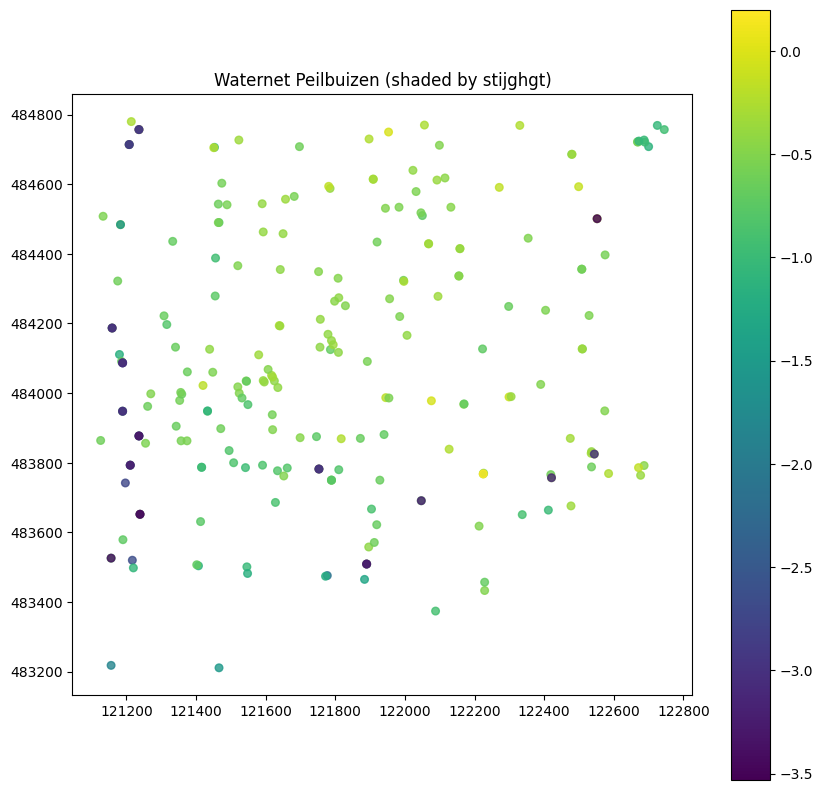

In [4]:
# Plot waternet_gdf with 'latest_stijghgt' shaded using the 'viridis' colormap
fig, ax = plt.subplots(figsize=(10, 10))
waternet_gdf.plot(
    ax=ax,
    column='latest_stijghgt',
    cmap='viridis',
    legend=True,
    alpha=0.8,
    markersize=30
)
ax.set_title('Waternet Peilbuizen (shaded by stijghgt)')
plt.show()

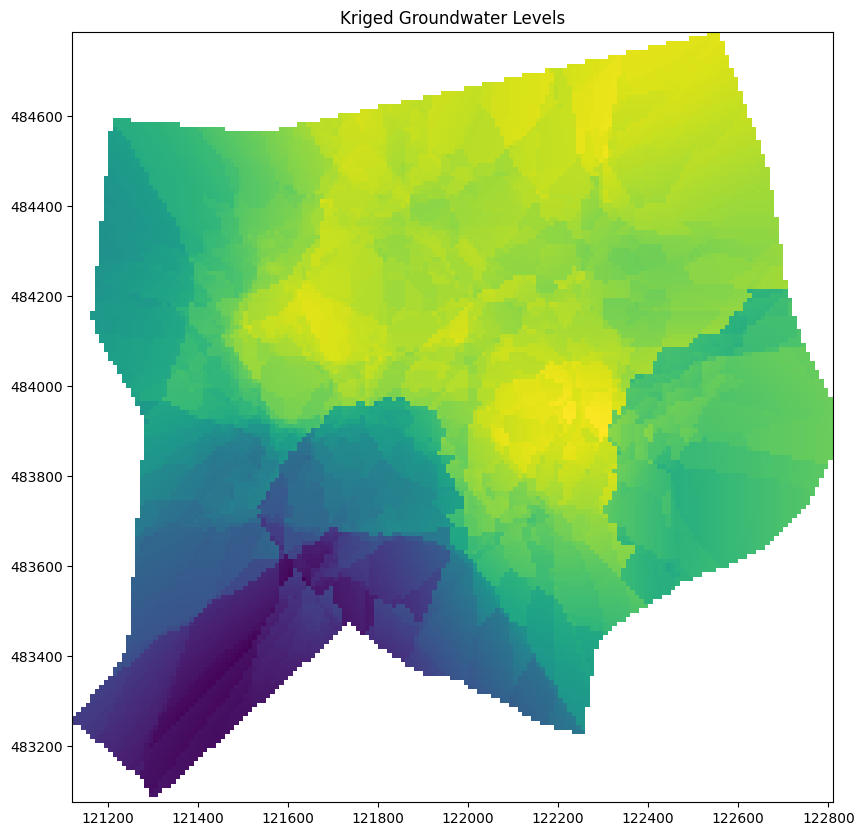

In [2]:
# Load the kriged groundwater levels using rasterio

kriged_groundwater = rio.open("./Data/kriged_groundwater.tif")

# Plot the kriged groundwater levels
fig, ax = plt.subplots(figsize=(10, 10))
show(kriged_groundwater, ax=ax, cmap='viridis')
ax.set_title('Kriged Groundwater Levels')
plt.show()
